# Diabetes Risk Prediction and Feature Selection
**Objective**: Use the BRFSS dataset to create a short form of questions (features) to accurately predict diabetes risk.


In [25]:
# Import Necessary Libraries
import pandas as pd  # For data manipulation and analysis
import numpy as np  # For numerical operations
from sklearn.model_selection import train_test_split  # For splitting the dataset into training and testing sets
from sklearn.ensemble import RandomForestClassifier  # For random forest classification (might be removed if not used later)
from imblearn.over_sampling import SMOTE  # For handling class imbalance using Synthetic Minority Oversampling Technique
import matplotlib.pyplot as plt  # For visualizations

In [26]:
# Load Dataset and Inspect Basic Information
file_path = "./data/diabetes_binary_health_indicators_BRFSS2015.csv"

# Load the dataset into a DataFrame
df = pd.read_csv(file_path)

# Display the shape and first few rows of the dataset
print(f"Dataset Shape: {df.shape}")  # Total rows and columns
print(df.head())  # Display the first 5 rows to understand the data structure


Dataset Shape: (253680, 22)
   Diabetes_binary  HighBP  HighChol  CholCheck   BMI  Smoker  Stroke  \
0              0.0     1.0       1.0        1.0  40.0     1.0     0.0   
1              0.0     0.0       0.0        0.0  25.0     1.0     0.0   
2              0.0     1.0       1.0        1.0  28.0     0.0     0.0   
3              0.0     1.0       0.0        1.0  27.0     0.0     0.0   
4              0.0     1.0       1.0        1.0  24.0     0.0     0.0   

   HeartDiseaseorAttack  PhysActivity  Fruits  ...  AnyHealthcare  \
0                   0.0           0.0     0.0  ...            1.0   
1                   0.0           1.0     0.0  ...            0.0   
2                   0.0           0.0     1.0  ...            1.0   
3                   0.0           1.0     1.0  ...            1.0   
4                   0.0           1.0     1.0  ...            1.0   

   NoDocbcCost  GenHlth  MentHlth  PhysHlth  DiffWalk  Sex   Age  Education  \
0          0.0      5.0      18.0      

In [27]:
# Define Features (X) and Target (y)

# Features: All columns except 'Diabetes_binary'
X = df.drop(columns=["Diabetes_binary"])

# Target: The 'Diabetes_binary' column (indicating diabetes status)
y = df["Diabetes_binary"]

# Display the shapes of features and target to confirm dimensions
print(f"Features Shape: {X.shape} (Number of rows: {X.shape[0]}, Number of features: {X.shape[1]})")
print(f"Target Shape: {y.shape} (Number of target values: {y.shape[0]})")


Features Shape: (253680, 21) (Number of rows: 253680, Number of features: 21)
Target Shape: (253680,) (Number of target values: 253680)


In [32]:
# Check for Missing Values
missing_values = df.isnull().sum()
print("Missing Values Per Column:")
print(missing_values)

# Confirm dataset cleanliness
if missing_values.sum() == 0:
    print("No missing values detected.")
else:
    print("Dataset contains missing values. Consider handling them before proceeding.")

Missing Values Per Column:
Diabetes_binary         0
HighBP                  0
HighChol                0
CholCheck               0
BMI                     0
Smoker                  0
Stroke                  0
HeartDiseaseorAttack    0
PhysActivity            0
Fruits                  0
Veggies                 0
HvyAlcoholConsump       0
AnyHealthcare           0
NoDocbcCost             0
GenHlth                 0
MentHlth                0
PhysHlth                0
DiffWalk                0
Sex                     0
Age                     0
Education               0
Income                  0
dtype: int64
No missing values detected.


In [33]:
# Check and Remove Duplicate Rows

# Check for duplicate rows
duplicate_count = df.duplicated().sum()

if duplicate_count > 0:
    print(f"\nDuplicate Rows Detected: {duplicate_count}")
    
    # Drop duplicate rows
    df = df.drop_duplicates()
    print("Duplicates removed. Remaining dataset shape:", df.shape)
else:
    print("No duplicate rows detected.")

No duplicate rows detected.


In [34]:
# Split the Dataset into Training and Testing Sets

# Use train_test_split to divide the dataset
# - 70% for training
# - 30% for testing
# - Stratify ensures the target variable ('Diabetes_binary') is equally distributed in both sets
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, random_state=42, stratify=y
)

# Display the shapes of training and testing sets
print(f"Training Features Shape: {X_train.shape} (Rows: {X_train.shape[0]}, Features: {X_train.shape[1]})")
print(f"Testing Features Shape: {X_test.shape} (Rows: {X_test.shape[0]}, Features: {X_test.shape[1]})")

# Display the distribution of the target variable in training and testing sets
print("\nTraining Target Distribution (Proportions):")
print(y_train.value_counts(normalize=True).rename_axis('Class').reset_index(name='Proportion'))

print("\nTesting Target Distribution (Proportions):")
print(y_test.value_counts(normalize=True).rename_axis('Class').reset_index(name='Proportion'))

Training Features Shape: (177576, 21) (Rows: 177576, Features: 21)
Testing Features Shape: (76104, 21) (Rows: 76104, Features: 21)

Training Target Distribution (Proportions):
   Class  Proportion
0    0.0    0.860668
1    1.0    0.139332

Testing Target Distribution (Proportions):
   Class  Proportion
0    0.0    0.860664
1    1.0    0.139336


In [35]:
# Basic Data Analysis: Understand Data Types and Summary

# Display data types and non-null counts
print("Data Types and Non-Null Counts:")
print(X.info())

# Display basic statistics for numerical features
print("\nBasic Statistics of Features:")
print(X.describe())

Data Types and Non-Null Counts:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 253680 entries, 0 to 253679
Data columns (total 21 columns):
 #   Column                Non-Null Count   Dtype  
---  ------                --------------   -----  
 0   HighBP                253680 non-null  float64
 1   HighChol              253680 non-null  float64
 2   CholCheck             253680 non-null  float64
 3   BMI                   253680 non-null  float64
 4   Smoker                253680 non-null  float64
 5   Stroke                253680 non-null  float64
 6   HeartDiseaseorAttack  253680 non-null  float64
 7   PhysActivity          253680 non-null  float64
 8   Fruits                253680 non-null  float64
 9   Veggies               253680 non-null  float64
 10  HvyAlcoholConsump     253680 non-null  float64
 11  AnyHealthcare         253680 non-null  float64
 12  NoDocbcCost           253680 non-null  float64
 13  GenHlth               253680 non-null  float64
 14  MentHlth            

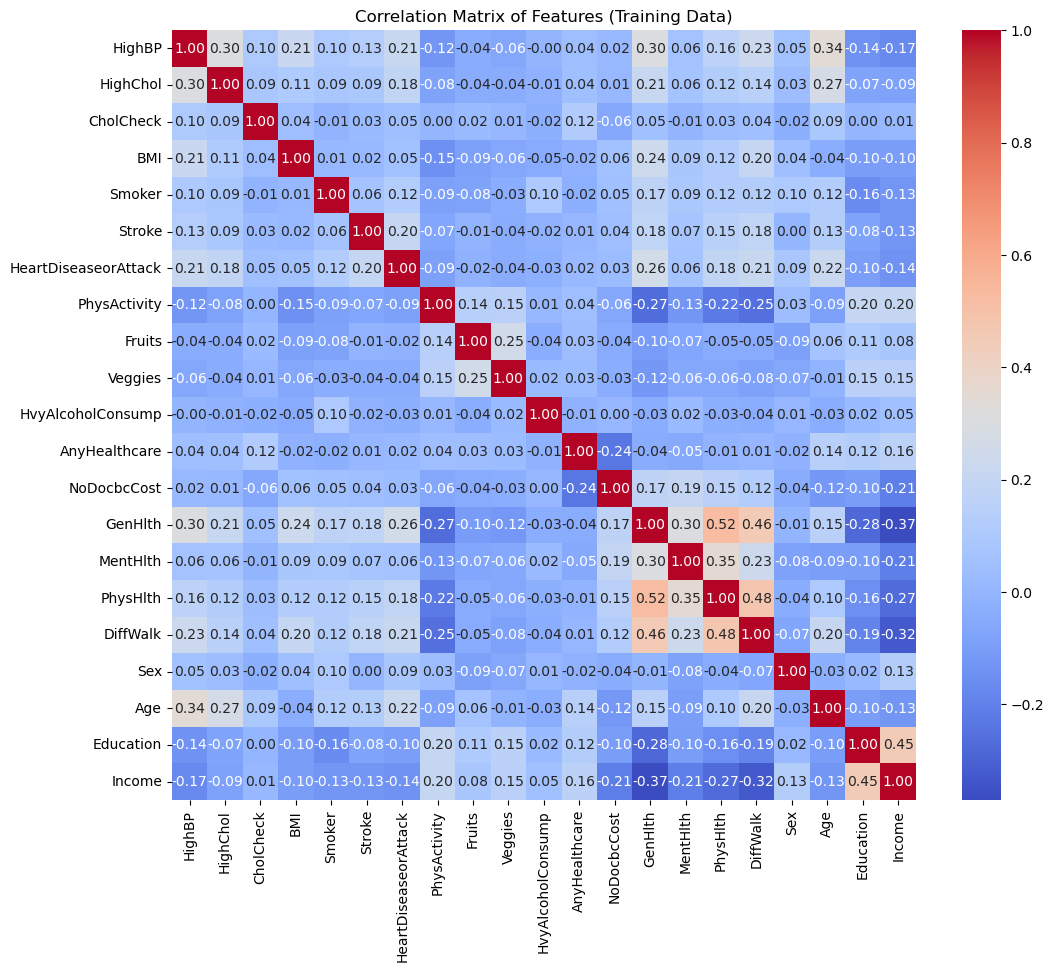

In [37]:
# Correlation Heatmap: Visualize Relationships Between Features

import seaborn as sns
import matplotlib.pyplot as plt

# Correlation matrix for the training data
plt.figure(figsize=(12, 10))
correlation_matrix = X_train.corr()

# Plot heatmap
sns.heatmap(correlation_matrix, annot=True, fmt=".2f", cmap="coolwarm", cbar=True)
plt.title("Correlation Matrix of Features (Training Data)")
plt.show()

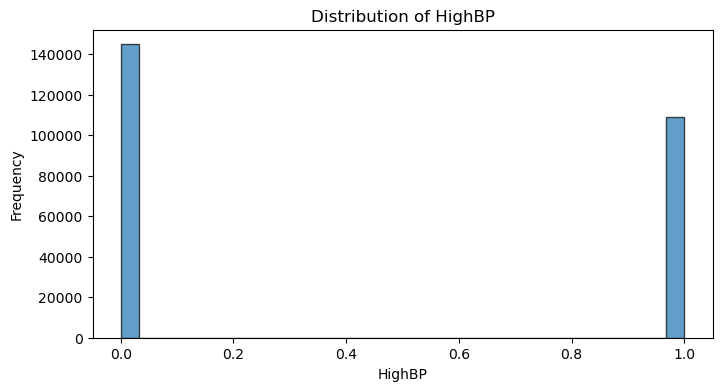

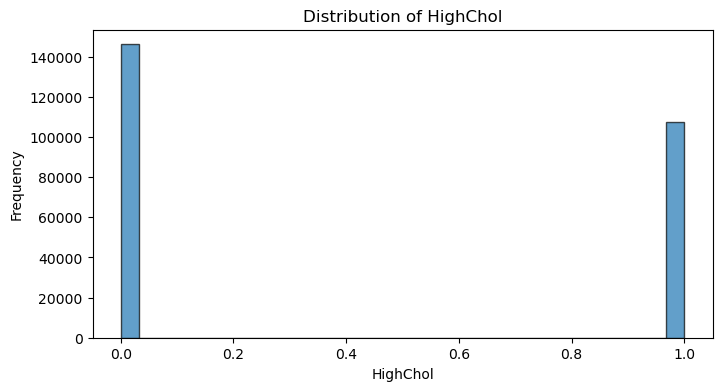

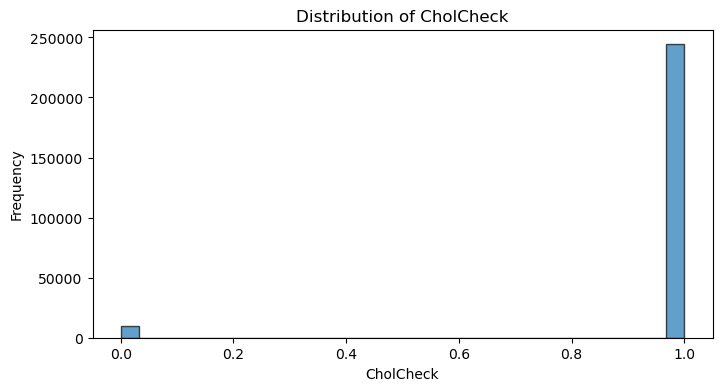

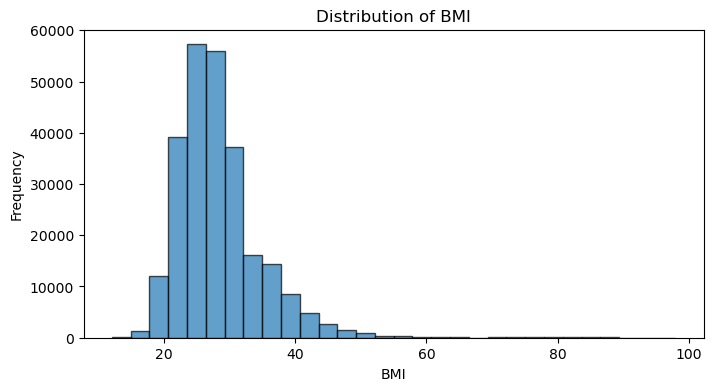

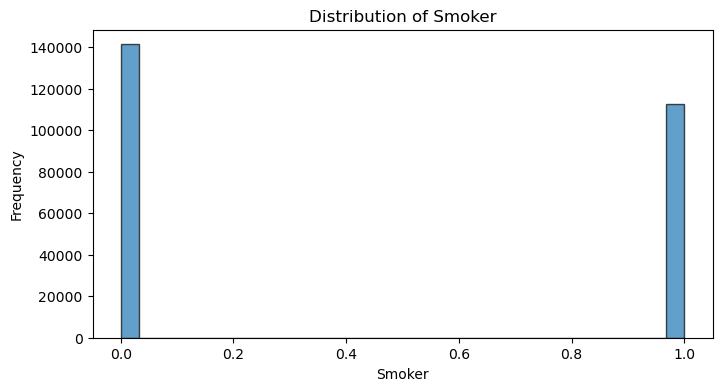

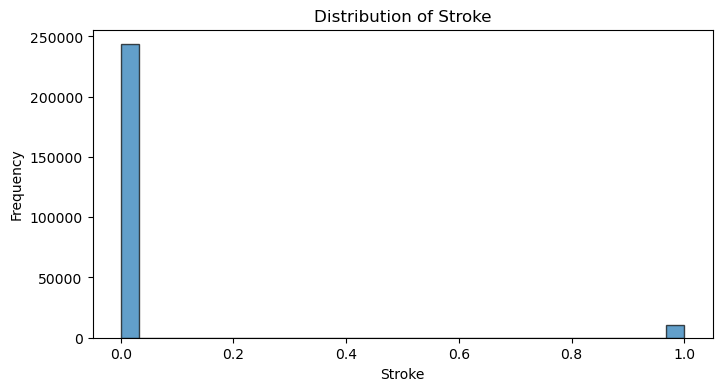

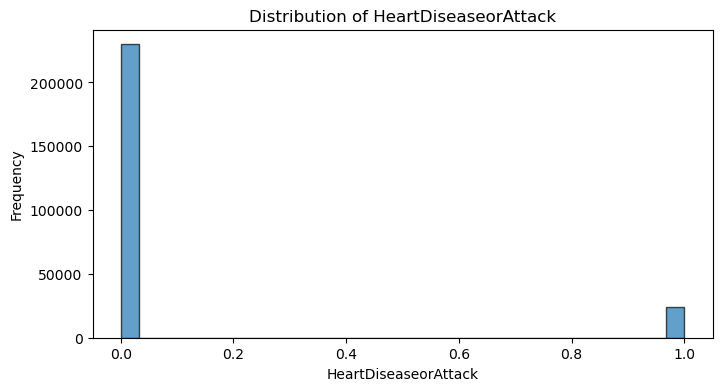

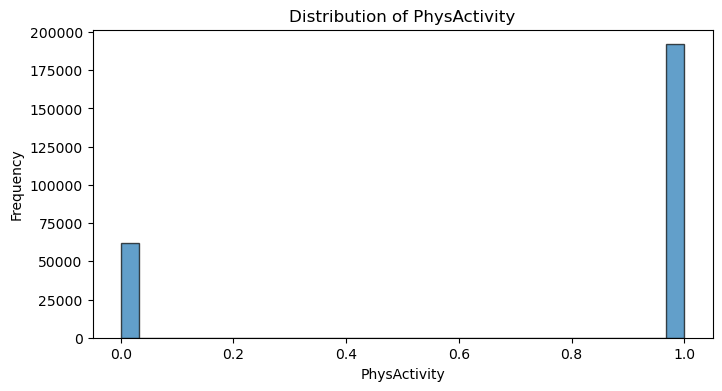

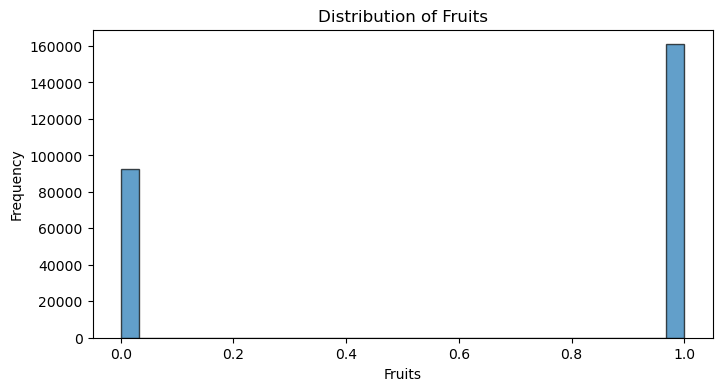

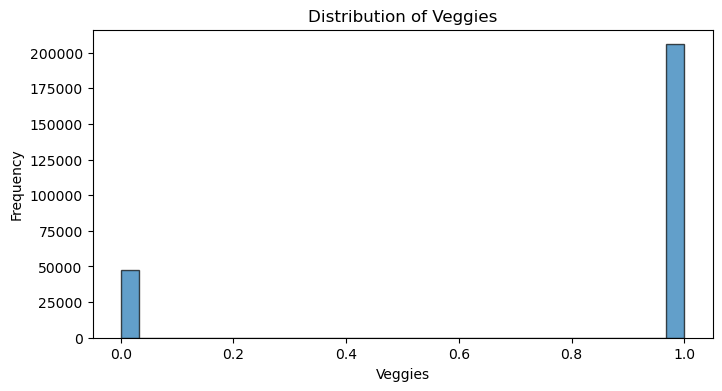

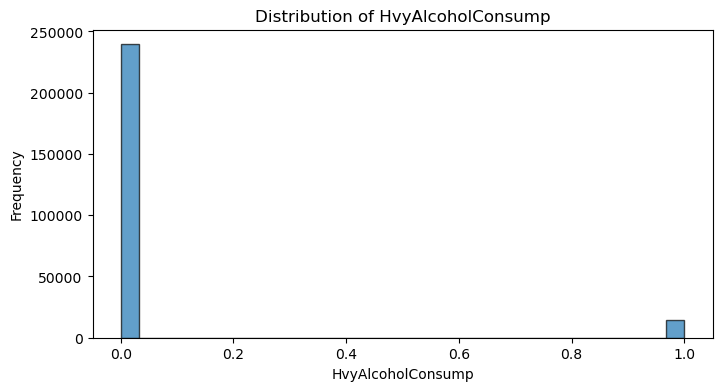

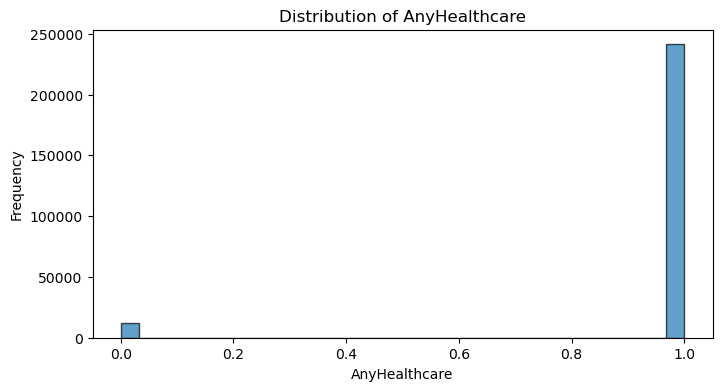

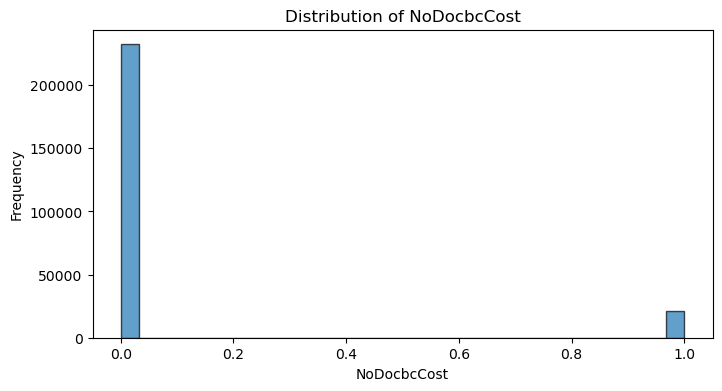

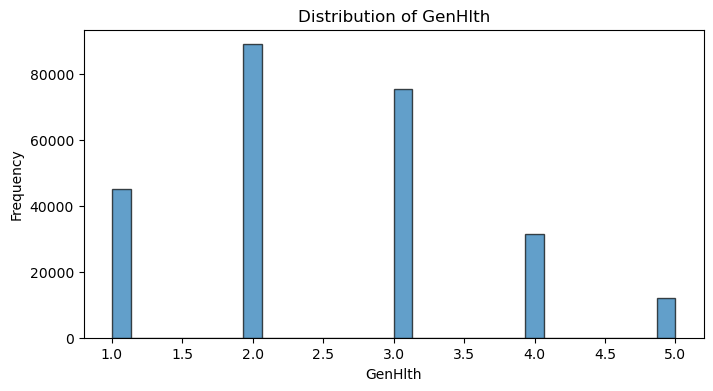

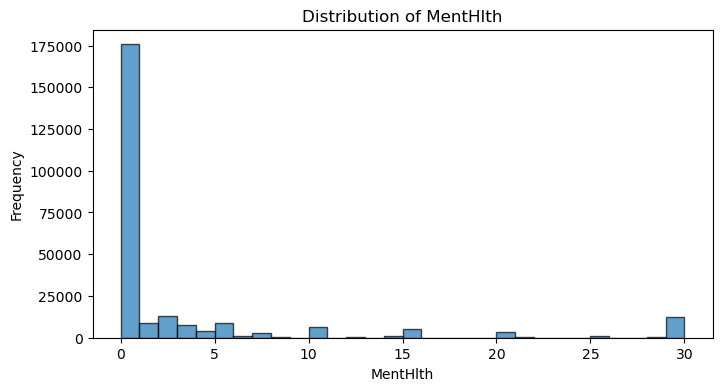

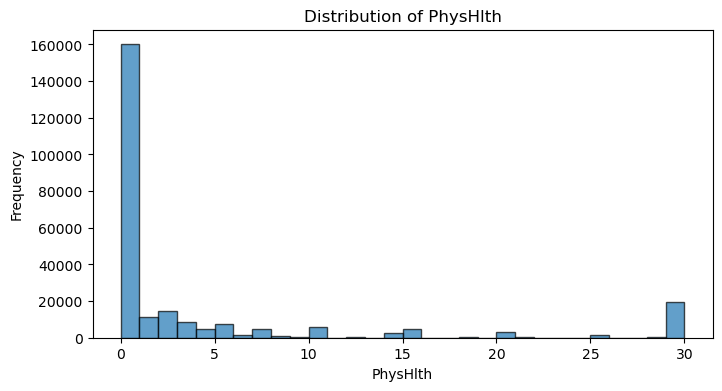

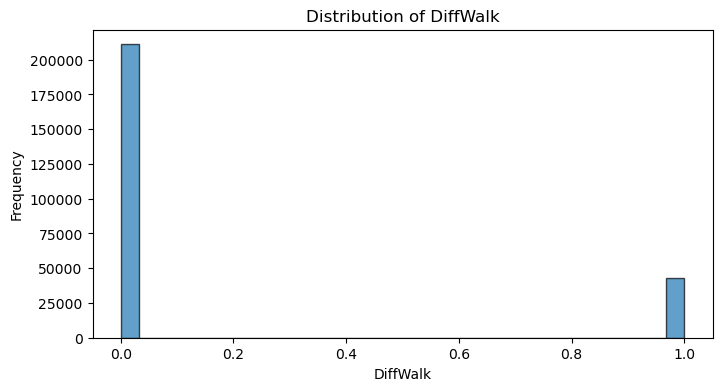

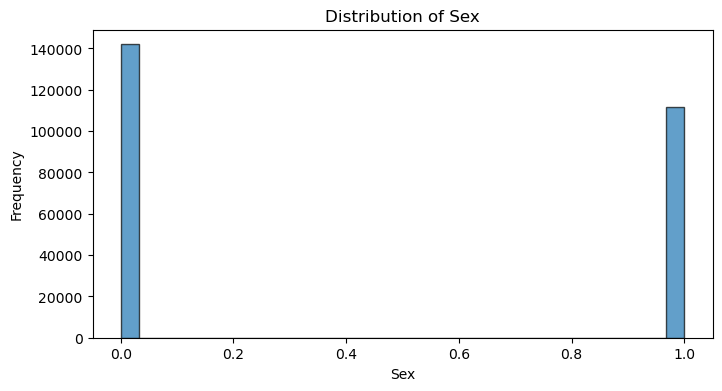

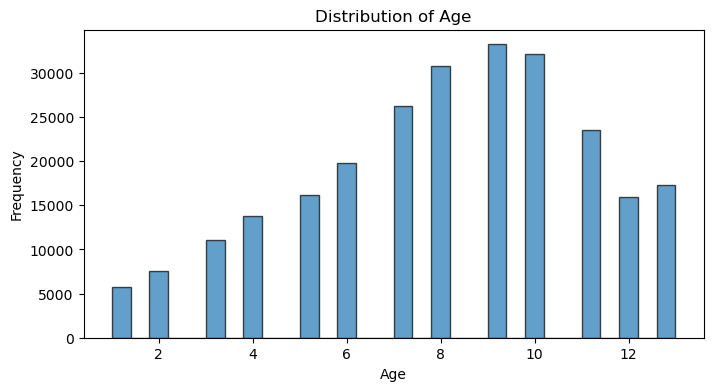

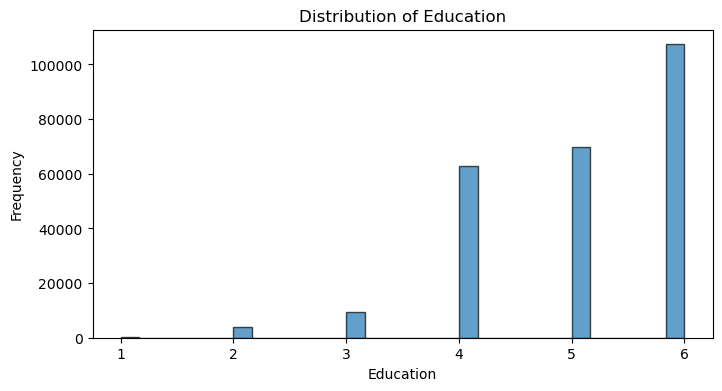

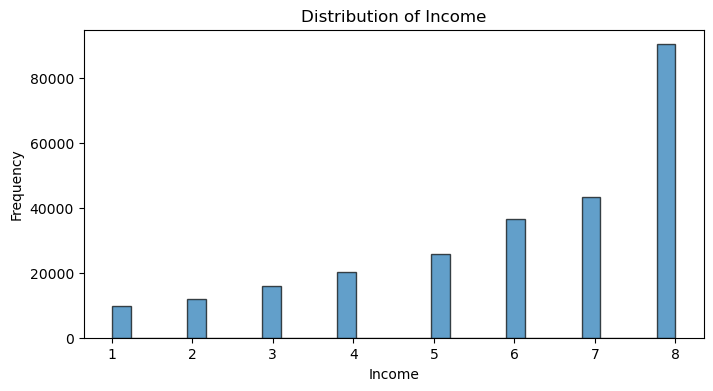

In [38]:
# Feature Distribution Visualization: Histograms for Numeric Features
numeric_features = X.select_dtypes(include=[np.number]).columns

# Plot histograms for numeric features
for feature in numeric_features:
    plt.figure(figsize=(8, 4))
    plt.hist(X[feature], bins=30, edgecolor="k", alpha=0.7)
    plt.title(f"Distribution of {feature}")
    plt.xlabel(feature)
    plt.ylabel("Frequency")
    plt.show()

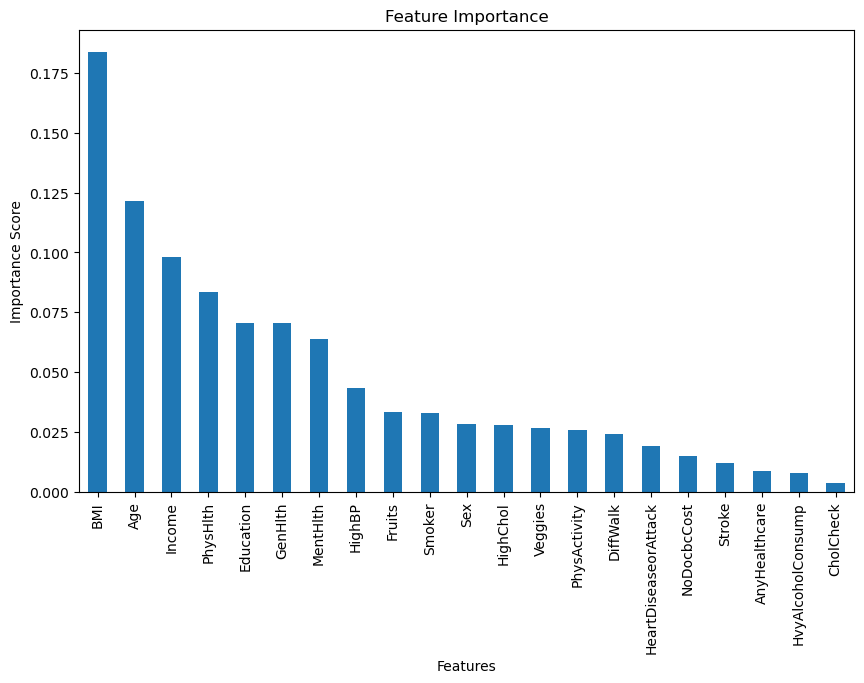

In [39]:
# Feature Importance Analysis with Random Forest
from sklearn.ensemble import RandomForestClassifier

# Train a basic Random Forest model
rf = RandomForestClassifier(random_state=42)
rf.fit(X_train, y_train)

# Extract feature importances
feature_importances = pd.Series(rf.feature_importances_, index=X.columns)
feature_importances.sort_values(ascending=False, inplace=True)

# Plot feature importances
plt.figure(figsize=(10, 6))
feature_importances.plot(kind="bar")
plt.title("Feature Importance")
plt.ylabel("Importance Score")
plt.xlabel("Features")
plt.show()

In [40]:
# Apply SMOTE to Training Data
from imblearn.over_sampling import SMOTE

smote = SMOTE(random_state=42)
X_train_resampled, y_train_resampled = smote.fit_resample(X_train, y_train)

# Inspect the resampled data
print(f"Resampled Training Features Shape: {X_train_resampled.shape}")
print(f"Resampled Training Target Distribution:\n{pd.Series(y_train_resampled).value_counts(normalize=True)}")

Resampled Training Features Shape: (305668, 21)
Resampled Training Target Distribution:
Diabetes_binary
0.0    0.5
1.0    0.5
Name: proportion, dtype: float64


In [41]:
# Select Top Features for Reduced Dataset
N = 5  # Number of top features to select
top_features = feature_importances.index[:N]

# Create reduced datasets
X_train_reduced = X_train_resampled[top_features]
X_test_reduced = X_test[top_features]

print(f"Selected Features: {list(top_features)}")
print(f"Reduced Training Features Shape: {X_train_reduced.shape}")
print(f"Reduced Testing Features Shape: {X_test_reduced.shape}")

Selected Features: ['BMI', 'Age', 'Income', 'PhysHlth', 'Education']
Reduced Training Features Shape: (305668, 5)
Reduced Testing Features Shape: (76104, 5)


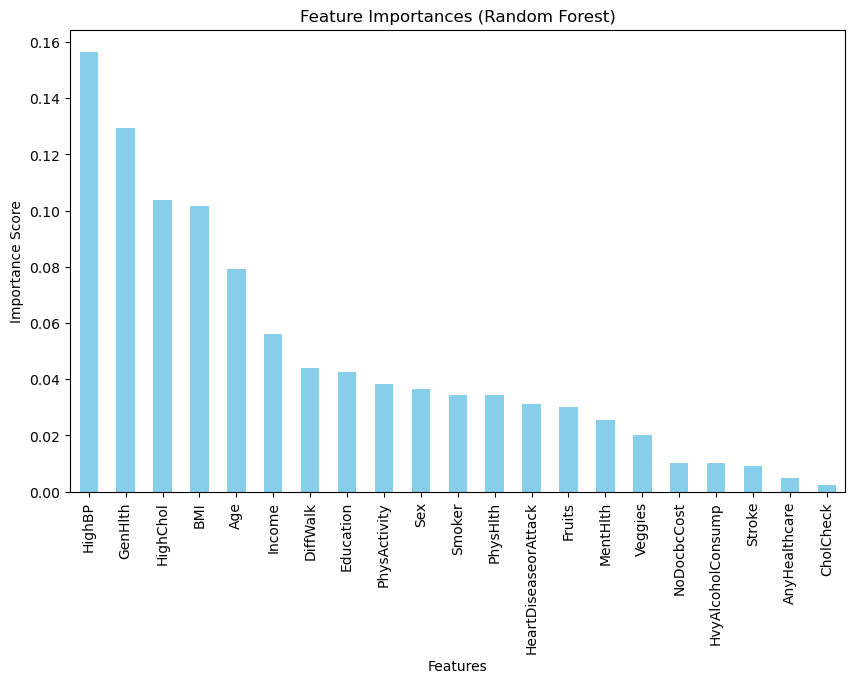

Selected Features: ['BMI', 'Age', 'Income', 'PhysHlth', 'Education']


In [42]:
# Train Random Forest and Selected Features 

# Train Random Forest for Feature Importance Analysis

clf = RandomForestClassifier(random_state=42)
clf.fit(X_train_resampled, y_train_resampled)

# Visualize feature importances
feature_importances = pd.Series(clf.feature_importances_, index=X.columns)
feature_importances.sort_values(ascending=False, inplace=True)

plt.figure(figsize=(10, 6))
feature_importances.plot(kind="bar", color="skyblue")
plt.title("Feature Importances (Random Forest)")
plt.ylabel("Importance Score")
plt.xlabel("Features")
plt.show()

# Confirm selected features
print(f"Selected Features: {list(top_features)}")


In [44]:
# Create Reduced Datasets using Selected Features

# Convert resampled training data to DataFrame
X_train_resampled = pd.DataFrame(X_train_resampled, columns=X.columns)

# Create reduced datasets
X_train_reduced = X_train_resampled[top_features]
X_test_reduced = X_test[top_features]

print(f"Reduced Training Features Shape: {X_train_reduced.shape}")
print(f"Reduced Testing Features Shape: {X_test_reduced.shape}")

Reduced Training Features Shape: (305668, 5)
Reduced Testing Features Shape: (76104, 5)


In [45]:
# Train and Evaluate Random Forest on Reduced Features

clf_reduced = RandomForestClassifier(random_state=42)
clf_reduced.fit(X_train_reduced, y_train_resampled)

# Predict on test set
y_pred_reduced = clf_reduced.predict(X_test_reduced)

# Evaluate the model
from sklearn.metrics import classification_report, accuracy_score

print("Classification Report (Reduced Features):")
print(classification_report(y_test, y_pred_reduced))

accuracy_reduced = accuracy_score(y_test, y_pred_reduced)
print(f"Accuracy with Reduced Features: {accuracy_reduced:.2f}")

Classification Report (Reduced Features):
              precision    recall  f1-score   support

         0.0       0.88      0.93      0.90     65500
         1.0       0.33      0.21      0.26     10604

    accuracy                           0.83     76104
   macro avg       0.60      0.57      0.58     76104
weighted avg       0.80      0.83      0.81     76104

Accuracy with Reduced Features: 0.83


In [46]:
# Compare Full and Reduced Feature Models

# Evaluate full model (trained on all features)
y_pred_full = clf.predict(X_test)
accuracy_full = accuracy_score(y_test, y_pred_full)

# Compare accuracy
print(f"Accuracy with Full Features: {accuracy_full:.2f}")
print(f"Accuracy with Reduced Features: {accuracy_reduced:.2f}")

Accuracy with Full Features: 0.86
Accuracy with Reduced Features: 0.83


In [47]:
# Save selected features to a CSV file
pd.DataFrame(top_features, columns=["Feature"]).to_csv("selected_features.csv", index=False)

print("Selected features saved.")

Selected features saved.


In [48]:
# Logistic Regression Model: Train and Evaluate Logistic Regression

from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, accuracy_score

# Use globally defined reduced datasets (based on selected top features)
# Ensuring that the datasets have the correct columns
X_train_reduced = X_train[top_features]  
X_test_reduced = X_test[top_features]

# Initialize Logistic Regression with balanced class weights
logreg = LogisticRegression(class_weight='balanced', random_state=42)

# Train the Logistic Regression model on the reduced training set
logreg.fit(X_train_reduced, y_train)

# Make predictions on the test set using the trained model
y_pred_logreg = logreg.predict(X_test_reduced)

# Evaluate model performance on the test set
print("\nLogistic Regression Results on Test Set:")
print(classification_report(y_test, y_pred_logreg))
print(f"Accuracy on Test Set: {accuracy_score(y_test, y_pred_logreg):.2f}")


Logistic Regression Results on Test Set:
              precision    recall  f1-score   support

         0.0       0.93      0.69      0.80     65500
         1.0       0.27      0.70      0.39     10604

    accuracy                           0.70     76104
   macro avg       0.60      0.70      0.59     76104
weighted avg       0.84      0.70      0.74     76104

Accuracy on Test Set: 0.70


In [49]:
# Gradient Boosting Model: Train and Evaluate XGBoost on Reduced Feature Set

from xgboost import XGBClassifier
from sklearn.metrics import classification_report, accuracy_score

# Initialize XGBoost Classifier
xgb = XGBClassifier(
    random_state=42,  # Ensures reproducibility
    use_label_encoder=False,  # Suppresses unnecessary warnings
    eval_metric="logloss"  # Evaluation metric used for classification
)

# Train the XGBoost model on the reduced training set
xgb.fit(X_train_reduced, y_train)

# Make predictions on the test set
y_pred_xgb = xgb.predict(X_test_reduced)

# Evaluate XGBoost model performance
print("\nXGBoost Results on Test Set:")
print(classification_report(y_test, y_pred_xgb))
print(f"Accuracy on Test Set: {accuracy_score(y_test, y_pred_xgb):.2f}")

/opt/anaconda3/envs/python310_env/lib/python3.10/site-packages/xgboost/core.py:158: UserWarning: [12:13:09] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)



XGBoost Results on Test Set:
              precision    recall  f1-score   support

         0.0       0.87      0.99      0.92     65500
         1.0       0.51      0.07      0.13     10604

    accuracy                           0.86     76104
   macro avg       0.69      0.53      0.53     76104
weighted avg       0.82      0.86      0.81     76104

Accuracy on Test Set: 0.86


In [51]:
# Model Comparison Table

# Create a DataFrame for comparison
comparison_data = {
    "Model": ["Random Forest", "Logistic Regression", "XGBoost"],
    "Accuracy": [0.83, 0.70, 0.86],
    "Precision (Class 1)": [0.33, 0.27, 0.51],
    "Recall (Class 1)": [0.21, 0.70, 0.07],
    "F1-Score (Class 1)": [0.26, 0.39, 0.13],
}

comparison_df = pd.DataFrame(comparison_data)

# Display the comparison table
print("Model Comparison Table:")
from tabulate import tabulate
print(tabulate(comparison_df, headers="keys", tablefmt="grid"))

Model Comparison Table:
+----+---------------------+------------+-----------------------+--------------------+----------------------+
|    | Model               |   Accuracy |   Precision (Class 1) |   Recall (Class 1) |   F1-Score (Class 1) |
+====+=====================+============+=======================+====================+======================+
|  0 | Random Forest       |       0.83 |                  0.33 |               0.21 |                 0.26 |
+----+---------------------+------------+-----------------------+--------------------+----------------------+
|  1 | Logistic Regression |       0.7  |                  0.27 |               0.7  |                 0.39 |
+----+---------------------+------------+-----------------------+--------------------+----------------------+
|  2 | XGBoost             |       0.86 |                  0.51 |               0.07 |                 0.13 |
+----+---------------------+------------+-----------------------+--------------------+----------

In [52]:
# Explanation of Model Selection

print("Model Selection:")
print("""
The goal of this project is to accurately predict diabetes risk (Class 1).
Among the evaluated models, Logistic Regression demonstrates the best ability to identify individuals at risk,
achieving a recall of 0.70 for Class 1. While XGBoost achieves the highest overall accuracy (0.86),
its recall for Class 1 is extremely low (0.07), making it unsuitable for the project's goal.
Random Forest provides decent accuracy (0.83), but it also struggles with identifying at-risk individuals
with a recall of only 0.21.

Based on these results, Logistic Regression is chosen as the best model for this project due to its balance
between recall and F1-Score for Class 1, prioritizing the reduction of false negatives in diabetes risk detection.
""")

Model Selection:

The goal of this project is to accurately predict diabetes risk (Class 1).
Among the evaluated models, Logistic Regression demonstrates the best ability to identify individuals at risk,
achieving a recall of 0.70 for Class 1. While XGBoost achieves the highest overall accuracy (0.86),
its recall for Class 1 is extremely low (0.07), making it unsuitable for the project's goal.
Random Forest provides decent accuracy (0.83), but it also struggles with identifying at-risk individuals
with a recall of only 0.21.

Based on these results, Logistic Regression is chosen as the best model for this project due to its balance
between recall and F1-Score for Class 1, prioritizing the reduction of false negatives in diabetes risk detection.



In [57]:
# Hyperparameter Tuning for Logistic Regression
from sklearn.model_selection import GridSearchCV

# Define parameter grid
param_grid = {
    'penalty': ['l1', 'l2', 'elasticnet', None],  # Regularization types
    'C': [0.1, 1, 10, 100],  # Regularization strength
    'solver': ['liblinear', 'saga'],  # Compatible solvers for L1 and ElasticNet
    'class_weight': [None, 'balanced']  # Handle class imbalance
}

# Perform grid search
grid_search_logreg = GridSearchCV(
    estimator=LogisticRegression(random_state=42, max_iter=5000),
    param_grid=param_grid,
    scoring='recall',  # Focus on recall for the minority class
    cv=5,  # 5-fold cross-validation
    n_jobs=-1  # Use all available cores
)

grid_search_logreg.fit(X_train_reduced, y_train)

# Get best parameters and model
logreg_optimized = grid_search_logreg.best_estimator_  # Updated to match the saving step
print(f"Best Parameters for Logistic Regression: {grid_search_logreg.best_params_}")

/opt/anaconda3/envs/python310_env/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1208: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/opt/anaconda3/envs/python310_env/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1208: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/opt/anaconda3/envs/python310_env/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1208: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/opt/anaconda3/envs/python310_env/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1208: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/opt/anaconda3/envs/python310_env/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1208: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/opt/anaconda3/envs/

Best Parameters for Logistic Regression: {'C': 0.1, 'class_weight': 'balanced', 'penalty': 'l2', 'solver': 'liblinear'}


In [58]:
# Evaluate Optimized Logistic Regression
y_pred_logreg_optimized = best_logreg.predict(X_test_reduced)

# Print Classification Report
print("Optimized Logistic Regression Results on Original Test Set:")
print(classification_report(y_test, y_pred_logreg_optimized))
print(f"Optimized Logistic Regression Accuracy: {accuracy_score(y_test, y_pred_logreg_optimized):.2f}")

Optimized Logistic Regression Results on Original Test Set:
              precision    recall  f1-score   support

         0.0       0.93      0.69      0.80     65500
         1.0       0.27      0.70      0.39     10604

    accuracy                           0.70     76104
   macro avg       0.60      0.70      0.59     76104
weighted avg       0.84      0.70      0.74     76104

Optimized Logistic Regression Accuracy: 0.70


In [59]:
# Final Model Comparison
comparison_data = {
    "Metric": [
        "Precision (Class 0)", "Precision (Class 1)", 
        "Recall (Class 0)", "Recall (Class 1)", 
        "F1-score (Class 0)", "F1-score (Class 1)", 
        "Overall Accuracy"
    ],
    "Optimized Logistic Regression": [0.93, 0.27, 0.69, 0.70, 0.80, 0.39, 0.70],
    "XGBoost": [0.87, 0.51, 0.99, 0.07, 0.92, 0.13, 0.86]
}

# Create DataFrame
comparison_df = pd.DataFrame(comparison_data)

# Display the Table
from IPython.display import display
display(comparison_df)

# Explanation of Results
print("""
Explanation of Results:

1. XGBoost:
    - Achieves higher overall accuracy (0.86) and F1-score for Class 0 (0.92).
    - However, it struggles with Class 1 recall (0.07), making it less effective for identifying diabetes risk in the high-risk category.

2. Optimized Logistic Regression:
    - While its overall accuracy (0.70) is lower, it performs significantly better in recall for Class 1 (0.70) and F1-score for Class 1 (0.39).
    - These metrics make it the preferred model for the goal of identifying high-risk diabetes cases, aligning better with the project's objective.

Conclusion:
The Optimized Logistic Regression model was selected as the final model for this project due to its superior performance in predicting high-risk diabetes cases (Class 1). This aligns with the primary goal of improving recall for high-risk individuals.
""")

,Metric,Optimized Logistic Regression,XGBoost
0,Precision (Class 0),0.93,0.87
1,Precision (Class 1),0.27,0.51
2,Recall (Class 0),0.69,0.99
3,Recall (Class 1),0.70,0.07
4,F1-score (Class 0),0.80,0.92
5,F1-score (Class 1),0.39,0.13
6,Overall Accuracy,0.70,0.86



Explanation of Results:

1. XGBoost:
    - Achieves higher overall accuracy (0.86) and F1-score for Class 0 (0.92).
    - However, it struggles with Class 1 recall (0.07), making it less effective for identifying diabetes risk in the high-risk category.

2. Optimized Logistic Regression:
    - While its overall accuracy (0.70) is lower, it performs significantly better in recall for Class 1 (0.70) and F1-score for Class 1 (0.39).
    - These metrics make it the preferred model for the goal of identifying high-risk diabetes cases, aligning better with the project's objective.

Conclusion:
The Optimized Logistic Regression model was selected as the final model for this project due to its superior performance in predicting high-risk diabetes cases (Class 1). This aligns with the primary goal of improving recall for high-risk individuals.



In [60]:
# Save the Optimized Logistic Regression Model
import joblib

model_filename = "optimized_logistic_regression_model.joblib"

# Save the model
joblib.dump(logreg_optimized, model_filename)

print(f"Model saved as {model_filename}")

Model saved as optimized_logistic_regression_model.joblib


In [61]:
# Train Long Form Model with All Features
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, accuracy_score
from joblib import dump

# Train logistic regression on all features
long_form_model = LogisticRegression(class_weight="balanced", random_state=42, max_iter=5000)
long_form_model.fit(X_train, y_train)

# Evaluate
y_pred_long = long_form_model.predict(X_test)
print("Long Form Logistic Regression Results:")
print(classification_report(y_test, y_pred_long))

# Save the long form model
dump(long_form_model, "long_form_model.joblib")

Long Form Logistic Regression Results:
              precision    recall  f1-score   support

         0.0       0.95      0.73      0.82     65500
         1.0       0.31      0.76      0.44     10604

    accuracy                           0.73     76104
   macro avg       0.63      0.74      0.63     76104
weighted avg       0.86      0.73      0.77     76104



['long_form_model.joblib']